# Restricted Boltzmann Machines - A bit of theory and a bit of practice

In this notebook we will explore Restricted Boltzman Machines (RBMs), undirected graphical models which implement a quite simple but interesting type of factorisation.

# Theory
An RBM assumes a generative model in which a set of *hidden units* $\mathbf{h}$ generate *visible units* $\mathbf{v}$.

The **energy** of a RBM configuration is defined as

$$
E(\mathbf{v}, \mathbf{h}) = -\sum_i a_i v_i -\sum_j b_j h_j - \sum_{i,j} v_i h_j w_{ij}
$$

where $\mathbf{a}, \mathbf{b}$ are bias parameters and $\mathbf{w_{ij}}$ is the weight of the connection between a visible unit $v_i$ and a hidden unit $h_j$.

As usual, we can move from the energy function to probabilities through the Gibbs function

$$
P(\mathbf{v}, \mathbf{h}) = \frac{1}{Z}e^{-E(\mathbf{v}, \mathbf{h})}
$$

where $Z = \sum_{\mathbf{v}, \mathbf{h}} e^{-E(\mathbf{v}, \mathbf{h})}$ is the partition function. Given the bipartitate nature of the graph (i.e. there are no connections between visible units nor between hidden units), conditional probabilities exhibit a very simple form

$$
P(\mathbf{v} | \mathbf{h}) = \sigma\left(\mathbf{W}\mathbf{h}\right)
$$
$$
P(\mathbf{h} | \mathbf{v}) = \sigma\left(\mathbf{v}^T\mathbf{W}\right)
$$
wher $\sigma(x) = \frac{1}{1+e^{-x}}$ is the sigmoid function. This will be very handy during the learning phase when we have to sample from those distributions: we can sample all of the visible / hidden units in parallel (block Gibbs sampling).

During learning we are naturally interested in maximising the marginal probability for the observations

$$
P(\mathbf{v}) = \sum_{\mathbf{h}} P(\mathbf{v}, \mathbf{h}) = \frac{1}{Z}\sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}
$$

How can we adjust the weights to maximise that objective? Let's first calculate the log likelihood, since that will simplify further calculations
$$
\ln P(\mathbf{v}) = \ln \sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})} - ln Z = \ln \sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})} - \sum_{\mathbf{v}, \mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}
$$

Let's look at the partial derivative of each one of those terms w.r.t. the weights

$$
\frac{\partial}{\partial w_{ij}} \ln \sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})} = \frac{1}{\sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}}\sum_{\mathbf{h}}(-1) e^{-E(\mathbf{v}, \mathbf{h})} \frac{\partial{E(\mathbf{v}, \mathbf{h})}}{\partial w_{ij}} = \frac{1}{\sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}}\sum_{\mathbf{h}}v_i h_j e^{-E(\mathbf{v}, \mathbf{h})}
$$
since $\frac{\partial E(\mathbf{v}, \mathbf{h})}{\partial w_{ij}} = -v_i h_j$. Moreover, since
$$
P(\mathbf{h} | \mathbf{v}) = \frac{P(\mathbf{v}, \mathbf{h})}{P(\mathbf{v})} 
= \frac{\frac{1}{Z}e^{-E(\mathbf{v}, \mathbf{h})}}{\frac{1}{Z}\sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}}
= \frac{e^{-E(\mathbf{v}, \mathbf{h})}}{\sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}}
$$

then we can write

$$
\frac{\partial}{\partial w_{ij}} \ln \sum_{\mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})} 
= \sum_{\mathbf{h}}v_i h_j P(\mathbf{h} | \mathbf{v})
$$

Which is an expectation over the conditional distribution for the hidden units activations given an input vector. 


Analogously:

$$
\frac{\partial}{\partial w_{ij}} \ln \sum_{\mathbf{v}, \mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})} 
= \frac{1}{\sum_{\mathbf{v}, \mathbf{h}}e^{-E(\mathbf{v}, \mathbf{h})}}\sum_{\mathbf{v}, \mathbf{h}}v_i h_j e^{-E(\mathbf{v}, \mathbf{h})}
= \sum_{\mathbf{v}, \mathbf{h}}v_i h_j P(\mathbf{v}, \mathbf{h}
$$

which is an expectation over the joint distribution of observable and latent variables.

Putting everything together
$$
\frac{\partial \ln P(\mathbf{v})}{\partial w_{ij}} = \sum_{\mathbf{h}}v_i h_j P(\mathbf{h} | \mathbf{v}) - \sum_{\mathbf{v}, \mathbf{h}}v_i h_j P(\mathbf{v}, \mathbf{h}) = \mathbb{E}_{\mathbf{h} | \mathbf{v}} v_i h_j - \mathbb{E}_{(\mathbf{v},\mathbf{h})} v_i h_j
$$

An stochastic gradient ascent (for the log-likelihood) approach to perform this optimisation would imply sampling from $P(\mathbf{h}|\mathbf{v})$ and $P(\mathbf{v}, \mathbf{h})$ and then calculating the outer product $\mathbf{v} \times \mathbf{h}$ on those samples. The expectation under the conditional probability of $\mathbf{h}$ is easy to get:

1. Sample the state of the hidden units given an input $\mathbf{v}$, yielding $\hat{\mathbf{h}}$
2. Get the outer product between the input and the sampled hidden activations $\mathbf{v} \times \hat{\mathbf{h}}$

The other term is more complex. A popular solution is **contrastive divergence**. Under that approach, samples from $P(\mathbf{v}, \mathbf{h})$ are constructed by 

1. Sample the state of the hidden units given an input $\mathbf{v}$, yielding $\hat{\mathbf{h}}$
2. Sample a new, reconstructed input from the value of the hidden units yielding $\hat{\mathbf{v}}$
3. Sample again the state of the hidden units given the reconstructed input, yielding $\tilde{\mathbf{h}}$
4. Calculate the outer product $\hat{\mathbf{v}} \times \tilde{\mathbf{h}}$

When we get to implement this we will see that there are a few details that are not totally clear. Things like: should I calculate the expectations using hard or soft activations? Does this only work for binary inputs or can I get away with continuous inputs?



# Coding it up

Let's start with some boilerplate so that we can plot images on the IPython notebook

In [269]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


## Let's get some data

We will be using the MNIST digits dataset (the Hello World of neural networks). We have a python-friendly pickled version downloaded from the [deeplearning.net](http://deeplearning.net/data/mnist/mnist.pkl.gz) website.

In [270]:
import cPickle
train, val, test = cPickle.load(open("/Users/dario/datasets/mnist/mnist.pkl", "r"))


In [271]:
# Each entry contains a tuple of (data, labels)
X_train, y_train = train
X_test, y_test = test
X_val, y_val = val


In [272]:
# Each row of the data matrices contains a 28x28 image concatenated into a single vector of 784 components
print X_train.shape
print X_val.shape
print X_test.shape


(50000, 784)
(10000, 784)
(10000, 784)


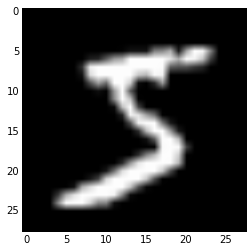

In [273]:
# Let's visualise an image
def show_digit(v):
    plt.imshow(v.reshape(28, 28), cmap=plt.cm.gray)
show_digit(X_train[0])


## Implementing an RBM

In [275]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


In [276]:
class RBM:
    # TODO: Currently we ignore the biases a and b
    def __init__(self, num_visible, num_hidden, W=None):
        #if with_bias is True:
        #    num_visible += 1
        self.num_visible = num_visible
        self.num_hidden  = num_hidden
        if W is None:
            W = 0.1 * np.random.randn(num_visible, num_hidden)
        #self.bias = with_bias
        self.W = W
    def energy(self, input_vector, hidden):
        #if self.bias:
        #    input_vector = np.insert(_input_vector, 0, 1)
        #else:
        #    input_vector = _input_vector
        return input_vector.dot(self.W.dot(hidden))
    def activation(self, input_vector):
        #if self.bias:
        #    input_vector = np.insert(_input_vector, 0, 1)
        #else:
        #    input_vector = _input_vector
        return logistic(input_vector.dot(self.W))
    def hard_activation(self, input_vector):
        p = self.activation(input_vector)
        thresh = np.random.rand(self.num_hidden)
        return (p > thresh).astype(int)
    def reconstruction_sample(self, input_vector):
        h = self.hard_activation(input_vector)
        visible_p = logistic(self.W.dot(h))
        #if self.bias is True:
        #    visible_p = visible_p[1:]
        return visible_p
    def CD1(self, v):
        # Simple contrastive divergence with a single
        # step of Gibbs sampling
        # 1 - Get the "data" contribution
        h_hat = self.hard_activation(v)
        data_term = np.outer(v, h_hat)
        # 2 - Get the "model" contribution
        d_hat = self.reconstruction_sample(v)
        h_tilde = self.activation(d_hat)
        model_term = np.outer(d_hat, h_tilde)
        return (data_term - model_term)
    def update(self, input_vector, learning_rate):
        self.W += learning_rate * self.CD1(input_vector)

Let's use our shiny RBM implementation to learn a representation for the MNIST digits

In [181]:
D = 784 + 1 # Input size for MNIST data with bias term
N = 100     # Hidden units
R = RBM(D, N)
lr = 0.0001
X_train_with_bias = [np.insert(v, 0, 1) for v in X_train]
for im in X_train_with_bias:
    R.update(im, lr)

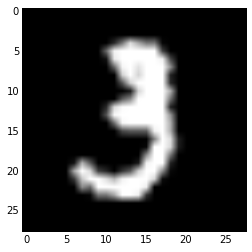

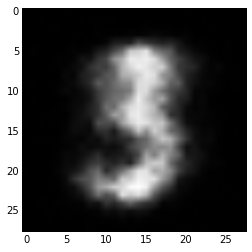

In [183]:
# Let's see what we've learnt
idx = 10
original_image = X_train[idx]
reco_image = R.reconstruction_sample(X_train_with_bias[idx])[1:]
show_digit(original_image)
plt.figure()
show_digit(reco_image)

Let's know use the activation probabilities for the units as features for learning a simple multiclass digit classifier using Naive Bayes

In [208]:
feats = [R.activation(i) for i in X_train_with_bias]

In [209]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(feats, y_train)

GaussianNB()

In [210]:
y_est_train = clf.predict(feats)
train_err = (y_est_train != y_train).mean()
print 'Training err: %.3f%%' % train_err

Training err: 0.267%


In [211]:
feats_test = [R.activation(np.insert(i, 0, 1)) for i in X_test]
y_est_test = clf.predict(feats_test)
test_err = (y_est_test != y_test).mean()
print 'Test error: %.3f%%' % test_err

Test error: 0.259%


If we want to use the RBM for classification purposes we should be a bit more thorough. Let use define now a helper function that will learn a RBM using early stopping based on classification error in the validation set.

In [280]:
import copy
def cv_learn_RBM(X_train, y_train, X_val, y_val, num_hidden, clf, lr=0.001, max_iter=50, stop_thresh=1e-3):
    # TODO: Better learning rate schedule
    R = RBM(X_train.shape[1] + 1, num_hidden)
    err_old = np.infty
    R_old = copy.deepcopy(R)
    for i in range(max_iter):
        print 'Pass %i' % i
        # Pass through the training data
        for im in [np.insert(i, 0, 1) for i in X_train]:
            R.update(im, lr)
        # Stopping criterion based on the validation set
        # 1 - Fit the classifier on the training set
        feats_train = [R.activation(np.insert(i, 0, 1)) for i in X_train]
        clf.fit(feats_train, y_train)
        # 2 - Evaluate on validation set
        feats_val = [R.activation(np.insert(i, 0, 1)) for i in X_val]
        y_est_val = clf.predict(feats_val)
        err_new = (y_est_val != y_val).mean()
        print 'Validation error after the pass: %.3f%%' % err_new
        if ((err_old - err_new) >= stop_thresh):
            break
        else:
            err_old = err_new
            lr = lr / 2
            R_old = copy.deepcopy(R)
    return R_old

So let's use this function to see what kind of performance we can extract. We will switch to a kNN classifier because ... well, because everybody knows they work pretty nicely for MNIST ;)

In [277]:
#clf = GaussianNB()
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(10)
R = cv_learn_RBM(X_train, y_train, X_val, y_val, N, clf, lr=0.01)

feats_test = [R.activation(np.insert(i, 0, 1)) for i in X_test]
y_est_test = clf.predict(feats_test)
test_err = (y_est_test != y_test).mean()
print 'Test error: %.3f%%' % (test_err*100)

Pass 0
Validation error after the pass: 0.034%
Pass 1
Validation error after the pass: 0.033%
Pass 2
Validation error after the pass: 0.033%
Test error: 0.035%


Not too bad for the effort! (still an order of magnitude worse than the best published results using convolutional nets, though). Let's take a look at the confusion matrix and then some specific errors

In [279]:
from sklearn.metrics import confusion_matrix
import pandas as pd
df = pd.DataFrame(confusion_matrix(y_test, y_est_test), columns=np.arange(10))
df
# Note: The first axis goes over the true labels, and the second one throught the estimated labels

,0,1,2,3,4,5,6,7,8,9
0,973,0,0,1,0,1,4,1,0,0
1,0,1129,3,0,0,0,3,0,0,0
2,12,1,998,4,1,0,1,9,5,1
3,3,0,3,971,1,9,0,7,12,4
4,3,2,1,0,939,0,7,1,1,28
5,10,0,0,21,1,844,9,2,2,3
6,7,2,0,0,2,3,944,0,0,0
7,1,16,10,0,2,0,1,975,2,21
8,11,1,2,12,6,8,3,3,924,4
9,11,6,2,9,13,3,0,10,6,949


We see that the most frequent mistakes for the system are misinterpreting 4s and 7s as 9s, and also misinterpreting 7s as 1s and 5s as 3s. Makes sense, doesn't it?

Since IPython is great, let's create a very simple widget that let's us explore the results of the system

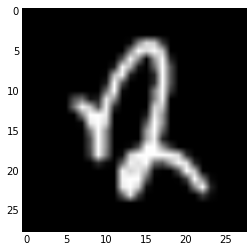

In [303]:
from IPython.html.widgets import interact
def show_example(real_class, est_class):
    samples = np.where((y_test == real_class) & (y_est_test == est_class))[0]
    if len(samples) > 0:
        if len(samples) == 1:
            idx = 0
        else:
            idx = np.random.randint(0, len(samples)-1)
        show_digit(X_test[samples[idx]])
    else:
        print 'No such case!'

interact(show_example, real_class=(0,9,1), est_class=(0,9,1))

# References
* http://image.diku.dk/igel/paper/AItRBM-proof.pd
* http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
